In [1]:
# Install missing package in the notebook environment (required to fix ModuleNotFoundError)
import tensorflow as tf
from tensorflow import keras
keras.backend.clear_session()
import pandas as pd
import numpy as np
from datetime import datetime
import seaborn as sns
from pyproj import Transformer
from sklearn.preprocessing import StandardScaler
from scipy.linalg import svd
import rasterio
from scipy.interpolate import griddata
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import rasterio
from scipy.interpolate import splprep, splev, Rbf
from scipy.spatial.distance import cdist
import warnings
warnings.filterwarnings('ignore')
import numpy as np
from scipy.interpolate import Rbf
from scipy.spatial import cKDTree
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
import warnings
warnings.filterwarnings('ignore')
# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (15, 8)
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.decomposition import TruncatedSVD
%pip install torch
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader


Note: you may need to restart the kernel to use updated packages.


In [2]:
# --- Read anomaly data ---
df_anom = pd.read_parquet("../data/df_illgraben_anomaly_scores.parquet", engine='fastparquet')
# --- Read coordinates ---
coords = pd.read_csv(
    "../data/coords.txt",
    sep="|",
    comment="#",
    header=None,
    engine="python"
)

col_names = [
    "Network","Station","Location","Channel","Latitude","Longitude","Elevation",
    "Depth","Azimuth","Dip","SensorDescription","Scale","ScaleFreq",
    "ScaleUnits","SampleRate","StartTime","EndTime"
]
coords.columns = col_names
coords = coords.iloc[1:]  # drop first row if header repetition

# Clean numeric columns
coords["Latitude"] = pd.to_numeric(coords["Latitude"], errors="coerce")
coords["Longitude"] = pd.to_numeric(coords["Longitude"], errors="coerce")
coords["Elevation"] = pd.to_numeric(coords["Elevation"], errors="coerce")

# Keep latest record per station
coords = (
    coords.sort_values(["Station", "StartTime"], ascending=[True, False])
    .drop_duplicates("Station")
    .reset_index(drop=True)
)[["Station", "Latitude", "Longitude", "Elevation"]]


In [3]:
transformer = Transformer.from_crs("epsg:4326", "epsg:2056", always_xy=True)
coords["X_mn95"], coords["Y_mn95"] = transformer.transform(coords["Longitude"].values, coords["Latitude"].values)


In [4]:
# Merge coords
df_merged = df_anom.merge(coords, left_on="station", right_on="Station", how="left")
df_merged = df_merged.dropna(subset=["X_mn95", "Y_mn95"])


In [5]:
print(df_merged.columns)

Index(['station', 'time', 'anomaly_score', 'std', 'debris flow', 'Station',
       'Latitude', 'Longitude', 'Elevation', 'X_mn95', 'Y_mn95'],
      dtype='object')


In [6]:
# Round time to nearest minute
df_merged['time_minute'] = df_merged['time'].dt.round('1min')

# Aggregate by station and minute
df_minute = (df_merged
             .groupby(['station', 'time_minute'])
             .agg({
                 'anomaly_score': 'mean',
                 'debris flow': 'max',  # If any reading in that minute has debris flow
                 'X_mn95': 'first',
                 'Y_mn95': 'first',
                 'Elevation': 'first'
             })
             .reset_index())

print(f"  Original readings: {len(df_merged):,}")
print(f"  After 1-min aggregation: {len(df_minute):,}")
print(f"  Time range: {df_minute['time_minute'].min()} to {df_minute['time_minute'].max()}")


  Original readings: 8,274,482
  After 1-min aggregation: 6,896,017
  Time range: 2018-05-14 11:03:00 to 2022-08-28 21:22:00


In [7]:
# Filter to June 2020
df_june = df_minute[
    (df_minute['time_minute'] >= '2020-06-01') & 
    (df_minute['time_minute'] < '2020-07-01')
].copy()

# Drop ILL14 and ILL15
df_june = df_june[~df_june['station'].isin(['ILL14', 'ILL15'])]

print(f"  June 2020 data points: {len(df_june):,}")
print(f"  Stations: {sorted(df_june['station'].unique())}")

  June 2020 data points: 259,075
  Stations: ['ILL11', 'ILL12', 'ILL13', 'ILL16', 'ILL17', 'ILL18']


In [ ]:
## DON'T RUN

# Define debris flow events (max 15-minute gap allowed)
def identify_debris_flow_events(df, max_gap_minutes=15):
    """
    Identify continuous debris flow events with allowed gaps.
    """
    # Sort by time
    df = df.sort_values('time_minute').copy()
    
    # Find where debris flow = 1
    debris_times = df[df['debris flow'] == 1]['time_minute'].unique()
    debris_times = pd.Series(sorted(debris_times))
    
    if len(debris_times) == 0:
        df['event_id'] = 0
        return df, pd.DataFrame()
    
    # Calculate time gaps between consecutive debris flow minutes
    time_diffs = debris_times.diff()
    
    # Start new event when gap > max_gap_minutes OR at the very first debris flow
    event_breaks = (time_diffs > pd.Timedelta(minutes=max_gap_minutes)) | (time_diffs.isna())
    event_ids = event_breaks.cumsum()  # This now starts at 1 for the first event
    
    # Create mapping from time to event_id
    time_to_event = pd.DataFrame({
        'time_minute': debris_times,
        'event_id': event_ids.values
    })
    
    # Merge back to main dataframe
    df = df.merge(time_to_event, on='time_minute', how='left')
    df['event_id'] = df['event_id'].fillna(0).astype(int)
    
    # Create event summary
    events_summary = (df[df['event_id'] > 0]
                     .groupby('event_id')
                     .agg({
                         'time_minute': ['min', 'max', 'count'],
                     }))
    events_summary.columns = ['start_time', 'end_time', 'n_minutes']
    events_summary['duration_min'] = (
        (events_summary['end_time'] - events_summary['start_time']).dt.total_seconds() / 60
    )
    
    return df, events_summary

df_june, events_summary = identify_debris_flow_events(df_june, max_gap_minutes=15)

print(f"\n  Debris flow events identified: {len(events_summary)}")
if len(events_summary) > 0:
    print(f"  Event durations (minutes): {events_summary['duration_min'].describe().to_dict()}")
    print("\n  Event details:")
    for event_id, row in events_summary.iterrows():
        print(f"    Event {event_id}: {row['start_time']} to {row['end_time']} "
              f"({row['duration_min']:.0f} min, {row['n_minutes']} readings)")

# Filter to keep only 30-minute windows before and after each event
if len(events_summary) > 0:
    window_minutes = 30
    
    # Create list of time ranges to keep
    keep_mask = pd.Series(False, index=df_june.index)
    
    for event_id, row in events_summary.iterrows():
        event_start = row['start_time']
        event_end = row['end_time']
        
        # Define window: 30 min before event to 30 min after event
        window_start = event_start - pd.Timedelta(minutes=window_minutes)
        window_end = event_end + pd.Timedelta(minutes=window_minutes)
        
        # Mark rows in this window
        in_window = (df_june['time_minute'] >= window_start) & (df_june['time_minute'] <= window_end)
        keep_mask |= in_window
        
        print(f"\n    Event {event_id} window: {window_start} to {window_end}")
    
    # Filter dataframe
    df_june_windowed = df_june[keep_mask].copy()
    
    print(f"\n  Original data: {len(df_june)} timepoints")
    print(f"  Windowed data: {len(df_june_windowed)} timepoints")
    print(f"  Reduction: {100 * (1 - len(df_june_windowed)/len(df_june)):.1f}%")
    
    # Use the windowed data for subsequent analysis
    df_june = df_june_windowed
else:
    print("\n  No debris flow events found - keeping all data")


  Debris flow events identified: 8
  Event durations (minutes): {'count': 8.0, 'mean': 107.5, 'std': 72.53570549342284, 'min': 15.0, '25%': 47.0, '50%': 115.5, '75%': 154.0, 'max': 220.0}

  Event details:
    Event 1: 2020-06-04 14:51:00 to 2020-06-04 17:21:00 (150 min, 906 readings)
    Event 2: 2020-06-07 07:10:00 to 2020-06-07 09:56:00 (166 min, 1002 readings)
    Event 3: 2020-06-08 13:38:00 to 2020-06-08 14:33:00 (55 min, 336 readings)
    Event 4: 2020-06-08 14:50:00 to 2020-06-08 15:13:00 (23 min, 144 readings)
    Event 5: 2020-06-08 15:44:00 to 2020-06-08 15:59:00 (15 min, 96 readings)
    Event 6: 2020-06-08 16:36:00 to 2020-06-08 18:45:00 (129 min, 780 readings)
    Event 7: 2020-06-17 03:18:00 to 2020-06-17 06:58:00 (220 min, 1326 readings)
    Event 8: 2020-06-29 04:29:00 to 2020-06-29 06:11:00 (102 min, 618 readings)

    Event 1 window: 2020-06-04 14:21:00 to 2020-06-04 17:51:00

    Event 2 window: 2020-06-07 06:40:00 to 2020-06-07 10:26:00

    Event 3 window: 2020-0

### Data Prep

In [29]:
# Split stations
train_stations = ['ILL13', 'ILL12', 'ILL16', 'ILL11', 'ILL17']
test_station = 'ILL18'

print(f"  Training stations: {train_stations}")
print(f"  Test station: {test_station}")

# Create wide format with ONLY training stations
df_wide_train = df_june[df_june['station'].isin(train_stations)].pivot(
    index='time_minute',
    columns='station',
    values='anomaly_score'
)

# Fill missing values
df_wide_train_filled = df_wide_train.fillna(method='ffill').fillna(method='bfill')

print(f"  Training data shape: {df_wide_train_filled.shape}")
print(f"  Time range: {df_wide_train_filled.index.min()} to {df_wide_train_filled.index.max()}")

# Get test station data (separate - not used in SVD)
df_test_station = df_june[df_june['station'] == test_station].set_index('time_minute')['anomaly_score']
df_test_station = df_test_station.reindex(df_wide_train_filled.index).fillna(method='ffill').fillna(method='bfill')

print(f"  Test station data shape: {df_test_station.shape}")

  Training stations: ['ILL13', 'ILL12', 'ILL16', 'ILL11', 'ILL17']
  Test station: ILL18
  Training data shape: (43200, 5)
  Time range: 2020-06-01 00:00:00 to 2020-06-30 23:59:00
  Test station data shape: (43200,)


In [30]:
# Standardize training data
# Fit scaler on training stations ONLY
scaler = StandardScaler()
train_data_scaled = scaler.fit_transform(df_wide_train_filled)

print(f"  Scaled data shape: {train_data_scaled.shape}")
print(f"  Mean per station: {scaler.mean_}")
print(f"  Std per station: {scaler.scale_}")

# FREEZE scaler parameters
FROZEN_SCALER_MEAN = scaler.mean_.copy()
FROZEN_SCALER_STD = scaler.scale_.copy()


  Scaled data shape: (43200, 5)
  Mean per station: [0.39941828 0.37959733 0.41791072 0.38233272 0.42475361]
  Std per station: [0.06384578 0.06030693 0.06553443 0.04296702 0.07590902]


### LSTM

In [31]:
# Split time into train/validation (80/20)
temporal_split_idx = int(len(df_wide_train_filled) * 0.8)

print(f"  Total timepoints: {len(df_wide_train_filled)}")
print(f"  Training timepoints: 0 to {temporal_split_idx}")
print(f"  Validation timepoints: {temporal_split_idx} to {len(df_wide_train_filled)}")

# Split training station data
train_data_scaled_train = train_data_scaled[:temporal_split_idx, :]
train_data_scaled_val = train_data_scaled[temporal_split_idx:, :]

# Split test station actual values
test_actual_train = df_test_station.values[:temporal_split_idx]
test_actual_val = df_test_station.values[temporal_split_idx:]

print(f"  Training data shape: {train_data_scaled_train.shape}")
print(f"  Validation data shape: {train_data_scaled_val.shape}")

  Total timepoints: 43200
  Training timepoints: 0 to 34560
  Validation timepoints: 34560 to 43200
  Training data shape: (34560, 5)
  Validation data shape: (8640, 5)


In [32]:
class DirectLSTM(nn.Module):
    def __init__(self, n_stations, lookback, hidden_size=32):
        super().__init__()
        
        self.lstm = nn.LSTM(
            input_size=n_stations,  # 5 training stations
            hidden_size=hidden_size,
            num_layers=2,
            batch_first=True,
            dropout=0.2
        )
        
        self.fc = nn.Linear(hidden_size, 1)
    
    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        last_output = lstm_out[:, -1, :]
        prediction = self.fc(last_output)
        return prediction

n_stations = len(train_stations)

print(f"  Architecture: Input({n_stations} stations) → LSTM(32 hidden) → Output(1)")

  Architecture: Input(5 stations) → LSTM(32 hidden) → Output(1)


In [33]:
class DirectForecastingDataset(Dataset):
    def __init__(self, train_data, test_actual, lookback=10, lag=10):
        self.train_data = train_data  # (n_timepoints, n_stations)
        self.test_actual = test_actual  # (n_timepoints,)
        self.lookback = lookback  # Window size (10 minutes)
        self.lag = lag            # Prediction lag (10 minutes)
    
    def __len__(self):
        # Need lookback + lag to make predictions
        return len(self.test_actual) - self.lookback - self.lag
    
    def __getitem__(self, idx):
        # Input: Training station data from [idx : idx+lookback]
        # This is [t-20, t-19, ..., t-10]
        train_window = self.train_data[idx:idx+self.lookback]  # (lookback, n_stations)
        
        # Target: ILL11 at time (idx + lookback + lag) which is time t
        target = self.test_actual[idx + self.lookback + self.lag]
        
        return torch.FloatTensor(train_window), torch.FloatTensor([target])

# Create datasets
lookback = 10  # 10-minute window
lag = 10       # 10-minute prediction lag

train_dataset = DirectForecastingDataset(train_data_scaled_train, test_actual_train, lookback, lag)
val_dataset = DirectForecastingDataset(train_data_scaled_val, test_actual_val, lookback, lag)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

print(f"  Lookback window: {lookback} minutes")
print(f"  Prediction lag: {lag} minutes")
print(f"  Train dataset size: {len(train_dataset)}")
print(f"  Validation dataset size: {len(val_dataset)}")
print(f"  Input: Anomaly scores from 5 stations at [t-{lookback+lag}:t-{lag}]")
print(f"  Example: Use station data from [t-20, t-10] to predict ILL11 at t")

  Lookback window: 10 minutes
  Prediction lag: 10 minutes
  Train dataset size: 34540
  Validation dataset size: 8620
  Input: Anomaly scores from 5 stations at [t-20:t-10]
  Example: Use station data from [t-20, t-10] to predict ILL11 at t


  Epoch 10/50 | Train Loss: 0.002130 | Val Loss: 0.002187
  Epoch 20/50 | Train Loss: 0.001838 | Val Loss: 0.002256
  Epoch 30/50 | Train Loss: 0.001621 | Val Loss: 0.003099
  Epoch 40/50 | Train Loss: 0.001473 | Val Loss: 0.003271
  Epoch 50/50 | Train Loss: 0.001358 | Val Loss: 0.003003
----------------------------------------------------------------------
  ✓ Training complete
  ✓ Best validation loss: 0.001892
  ✓ Saved: lstm_direct_10min_lag_training_curves.png


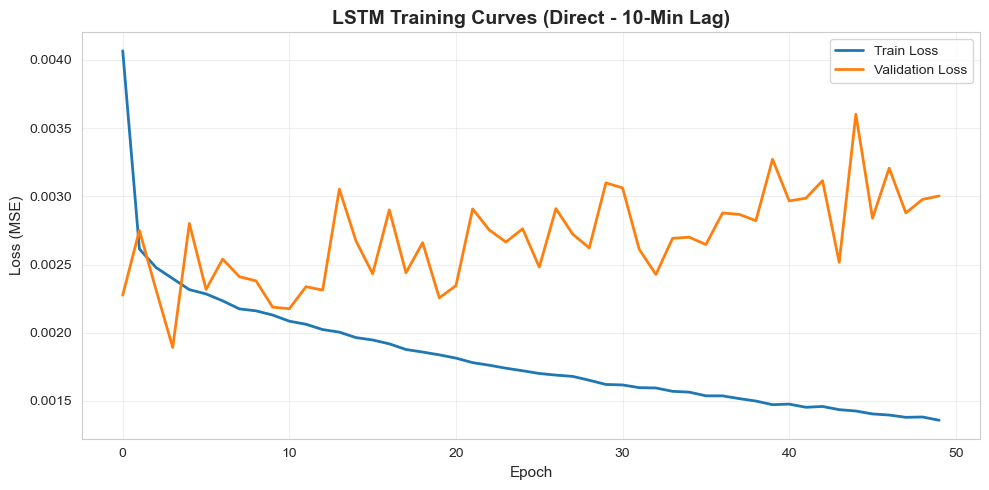

In [34]:
# Initialize model
model = DirectLSTM(n_stations=n_stations, lookback=lookback, hidden_size=32)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
n_epochs = 50
best_val_loss = float('inf')
best_model_state = None

train_losses = []
val_losses = []

for epoch in range(n_epochs):
    # Train
    model.train()
    train_loss = 0
    for train_window, target in train_loader:
        optimizer.zero_grad()
        prediction = model(train_window)
        loss = criterion(prediction, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    
    # Validate
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for train_window, target in val_loader:
            prediction = model(train_window)
            loss = criterion(prediction, target)
            val_loss += loss.item()
    
    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    
    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = model.state_dict().copy()
    
    if (epoch + 1) % 10 == 0:
        print(f'  Epoch {epoch+1}/{n_epochs} | Train Loss: {train_loss:.6f} | Val Loss: {val_loss:.6f}')

# Load best model
model.load_state_dict(best_model_state)

print("-"*70)
print(f"  ✓ Training complete")
print(f"  ✓ Best validation loss: {best_val_loss:.6f}")

# Plot training curves
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(train_losses, label='Train Loss', linewidth=2)
ax.plot(val_losses, label='Validation Loss', linewidth=2)
ax.set_xlabel('Epoch', fontsize=11)
ax.set_ylabel('Loss (MSE)', fontsize=11)
ax.set_title('LSTM Training Curves (Direct - 10-Min Lag)', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('lstm_direct_10min_lag_training_curves.png', dpi=300, bbox_inches='tight')
print("  ✓ Saved: lstm_direct_10min_lag_training_curves.png")
plt.show()

### Prediction

In [35]:
# Predict on validation set
model.eval()
predictions_val = []

with torch.no_grad():
    for train_window, _ in val_loader:
        pred = model(train_window)
        predictions_val.extend(pred.numpy().flatten())

predictions_val = np.array(predictions_val)

# Also predict on full dataset for visualization
predictions_full = np.zeros(len(df_test_station))
predictions_full[:] = np.nan  # Initialize with NaN

model.eval()
with torch.no_grad():
    for i in range(lookback + lag, len(train_data_scaled)):
        # Use data from [i-lookback-lag : i-lag]
        # This is [t-20 : t-10] when predicting at time t
        train_window = train_data_scaled[i-lookback-lag:i-lag]
        train_tensor = torch.FloatTensor(train_window).unsqueeze(0)
        pred = model(train_tensor).item()
        predictions_full[i] = pred

# Metrics on validation set
actual_val = test_actual_val[lookback + lag:]

rmse_val = np.sqrt(mean_squared_error(actual_val, predictions_val))
mae_val = mean_absolute_error(actual_val, predictions_val)
r2_val = r2_score(actual_val, predictions_val)

print("\n" + "="*70)
print("VALIDATION SET RESULTS (DIRECT LSTM - 10-MIN LAG)")
print("="*70)
print(f"  RMSE: {rmse_val:.4f}")
print(f"  MAE:  {mae_val:.4f}")
print(f"  R²:   {r2_val:.4f}")

# Metrics on debris flow times only
debris_flow_indicator = df_june.groupby('time_minute')['debris flow'].max()
debris_flow_indicator = debris_flow_indicator.reindex(df_wide_train_filled.index).fillna(0)

debris_mask_val = debris_flow_indicator.values[temporal_split_idx+lookback+lag:] == 1

if debris_mask_val.sum() > 0:
    rmse_debris = np.sqrt(mean_squared_error(actual_val[debris_mask_val], predictions_val[debris_mask_val]))
    mae_debris = mean_absolute_error(actual_val[debris_mask_val], predictions_val[debris_mask_val])
    r2_debris = r2_score(actual_val[debris_mask_val], predictions_val[debris_mask_val])
    
    print("\nDEBRIS FLOW TIMES ONLY (Validation Set):")
    print(f"  RMSE: {rmse_debris:.4f}")
    print(f"  MAE:  {mae_debris:.4f}")
    print(f"  R²:   {r2_debris:.4f}")
    print(f"  Number of debris flow timepoints: {debris_mask_val.sum()}")
else:
    print("\nNo debris flow events in validation set")


VALIDATION SET RESULTS (DIRECT LSTM - 10-MIN LAG)
  RMSE: 0.0548
  MAE:  0.0348
  R²:   -0.0693

DEBRIS FLOW TIMES ONLY (Validation Set):
  RMSE: 0.1313
  MAE:  0.0968
  R²:   -0.2612
  Number of debris flow timepoints: 103


  Saved: svd_lstm_predictions_full.png


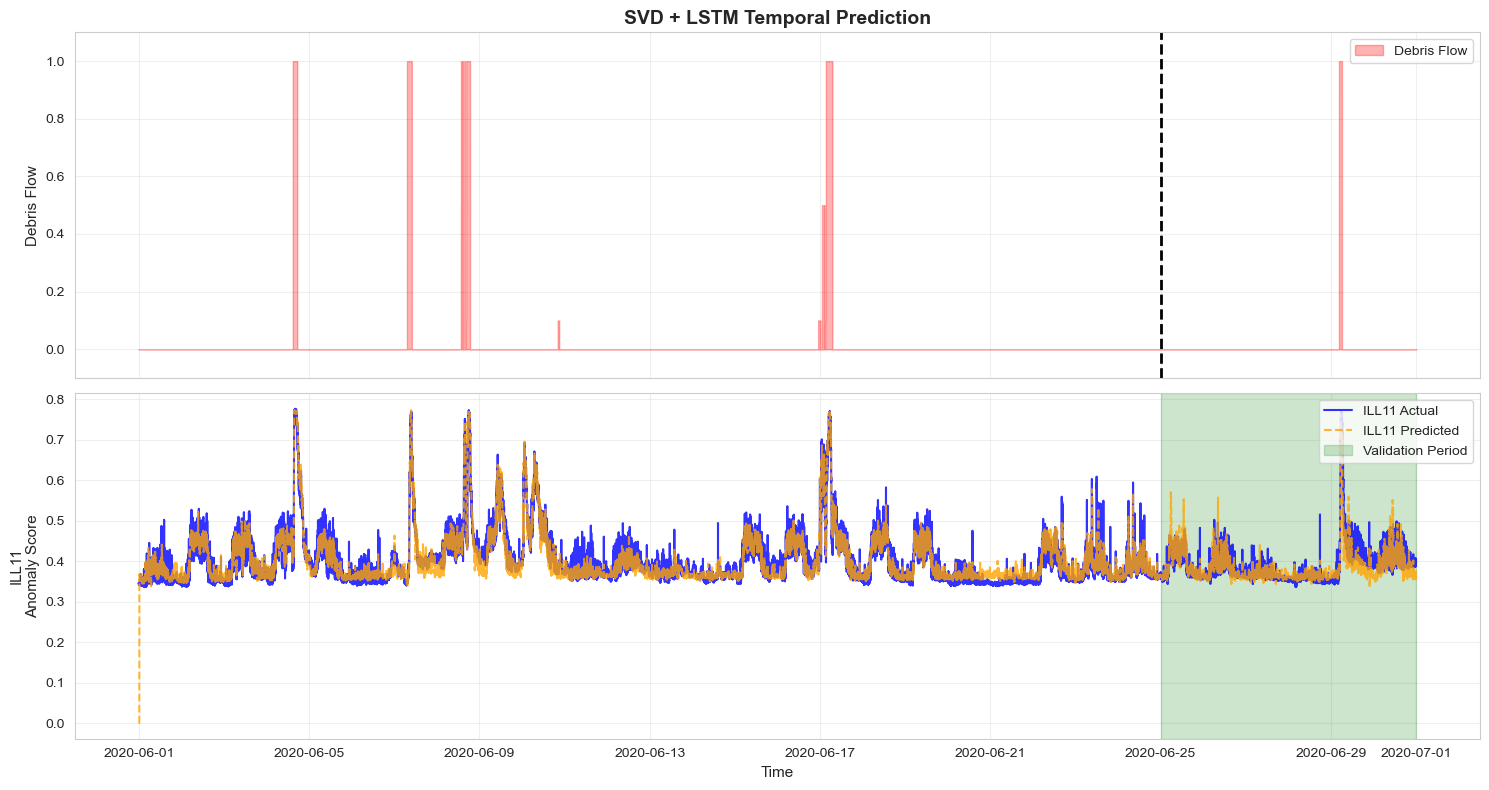

  Saved: svd_lstm_scatter_validation.png


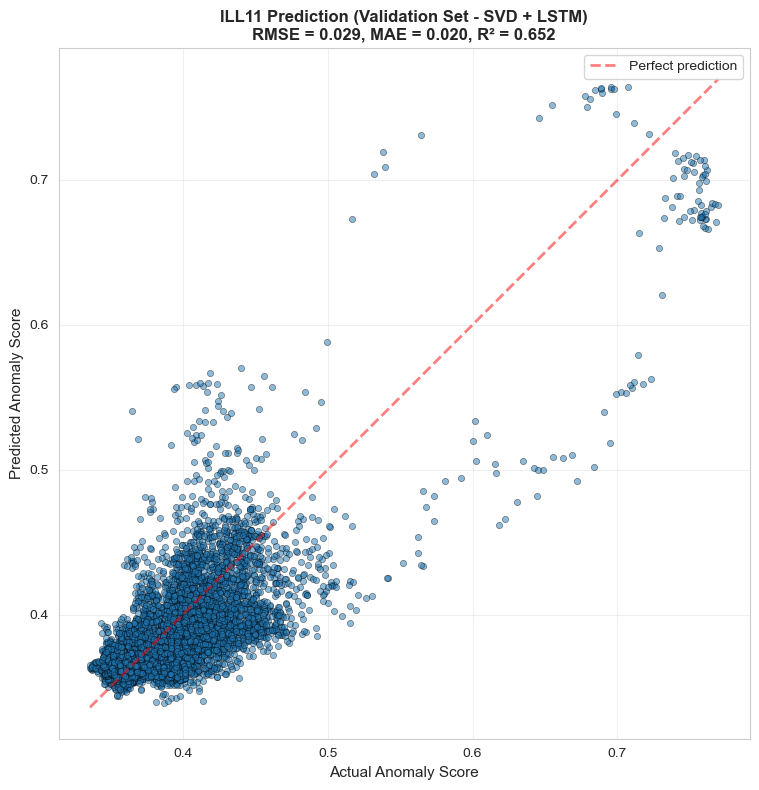

  Saved: svd_lstm_scatter_debris_flow.png


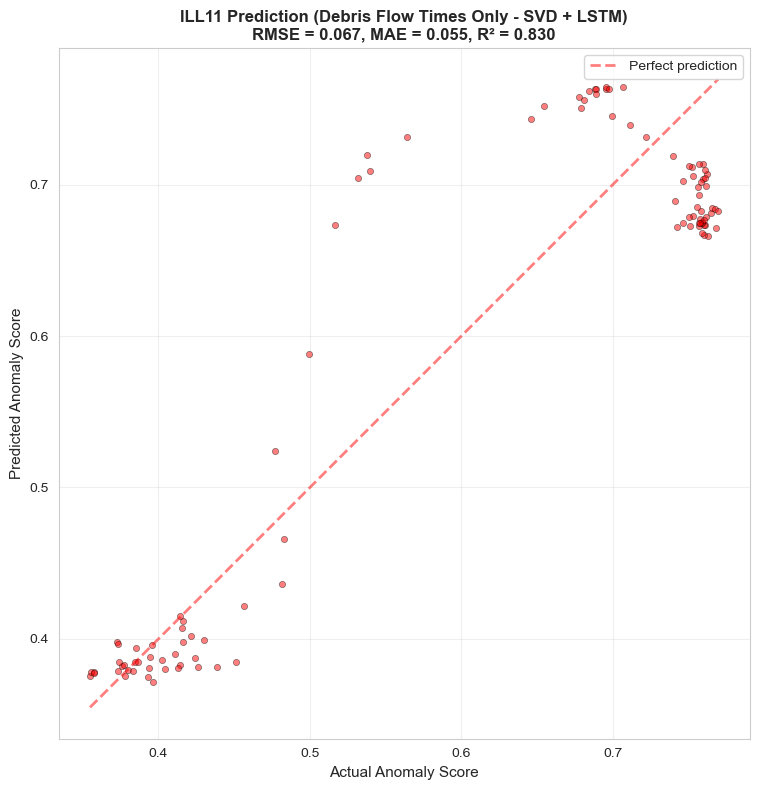


Summary:
  SVD fitted on 5 training stations only
  Test station (ILL11) never seen by SVD
  Temporal components (U) frozen during prediction
  LSTM trained on 34540 samples
  Validated on 8620 samples
  Final R² on validation set: 0.6521


In [ ]:
# Full time series plot
fig, axes = plt.subplots(2, 1, figsize=(15, 8), sharex=True)

# Debris flow indicator
axes[0].fill_between(df_wide_train_filled.index, 0, 
                     debris_flow_indicator.values, 
                     alpha=0.3, color='red', label='Debris Flow')
axes[0].set_ylabel('Debris Flow', fontsize=11)
axes[0].set_ylim([-0.1, 1.1])
axes[0].legend(loc='upper right')
axes[0].set_title('Direct LSTM with 10-Minute Lag (Raw Anomaly Scores)', 
                  fontsize=14, fontweight='bold')
axes[0].grid(alpha=0.3)

# Add vertical line at train/val split
axes[0].axvline(df_wide_train_filled.index[temporal_split_idx], 
                color='black', linestyle='--', linewidth=2, label='Train/Val Split')

# Predictions vs actual
axes[1].plot(df_wide_train_filled.index, df_test_station.values,
            label=f'{test_station} Actual', linewidth=1.5, alpha=0.8, color='blue')
axes[1].plot(df_wide_train_filled.index, predictions_full,
            label=f'{test_station} Predicted (10-min lag)', linewidth=1.5, alpha=0.8, 
            color='orange', linestyle='--')

# Shade validation period
axes[1].axvspan(df_wide_train_filled.index[temporal_split_idx], 
                df_wide_train_filled.index[-1],
                alpha=0.2, color='green', label='Validation Period')

axes[1].set_ylabel(f'{test_station}\nAnomaly Score', fontsize=11)
axes[1].set_xlabel('Time', fontsize=11)
axes[1].legend(loc='upper right')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('lstm_direct_10min_lag_full.png', dpi=300, bbox_inches='tight')
print("  ✓ Saved: lstm_direct_10min_lag_full.png")
plt.show()

# Scatter plot - validation set only
fig, ax = plt.subplots(1, 1, figsize=(8, 8))

ax.scatter(actual_val, predictions_val, alpha=0.5, s=20, edgecolors='black', linewidth=0.5)

# Add diagonal line
lims = [min(actual_val.min(), predictions_val.min()),
        max(actual_val.max(), predictions_val.max())]
ax.plot(lims, lims, 'r--', alpha=0.5, linewidth=2, label='Perfect prediction')

ax.set_xlabel('Actual Anomaly Score', fontsize=11)
ax.set_ylabel('Predicted Anomaly Score', fontsize=11)
ax.set_title(f'{test_station} Direct LSTM (Validation Set - 10-Min Lag)\n'
             f'RMSE = {rmse_val:.3f}, MAE = {mae_val:.3f}, R² = {r2_val:.3f}\n'
             f'(Using raw station data from [t-20, t-10])',
             fontsize=12, fontweight='bold')
ax.legend()
ax.grid(alpha=0.3)
ax.set_aspect('equal')

plt.tight_layout()
plt.savefig('lstm_direct_10min_lag_scatter_validation.png', dpi=300, bbox_inches='tight')
print("  ✓ Saved: lstm_direct_10min_lag_scatter_validation.png")
plt.show()

# Debris flow times scatter (if available)
if debris_mask_val.sum() > 0:
    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    
    ax.scatter(actual_val[debris_mask_val], predictions_val[debris_mask_val], 
               alpha=0.5, s=20, edgecolors='black', linewidth=0.5, color='red')
    
    lims = [min(actual_val[debris_mask_val].min(), predictions_val[debris_mask_val].min()),
            max(actual_val[debris_mask_val].max(), predictions_val[debris_mask_val].max())]
    ax.plot(lims, lims, 'r--', alpha=0.5, linewidth=2, label='Perfect prediction')
    
    ax.set_xlabel('Actual Anomaly Score', fontsize=11)
    ax.set_ylabel('Predicted Anomaly Score', fontsize=11)
    ax.set_title(f'{test_station} Direct LSTM (Debris Flow Times Only - 10-Min Lag)\n'
                 f'RMSE = {rmse_debris:.3f}, MAE = {mae_debris:.3f}, R² = {r2_debris:.3f}',
                 fontsize=12, fontweight='bold')
    ax.legend()
    ax.grid(alpha=0.3)
    ax.set_aspect('equal')
    
    plt.tight_layout()
    plt.savefig('lstm_direct_10min_lag_scatter_debris_flow.png', dpi=300, bbox_inches='tight')
    print("  ✓ Saved: lstm_direct_10min_lag_scatter_debris_flow.png")
    plt.show()